In [152]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import optuna

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

### 1. Получите данные и загрузите их в рабочую среду. 

In [153]:
current_directory = Path.cwd()
DATA_PATH = current_directory.parent / 'data/heart.csv'

In [154]:
data = pd.read_csv(DATA_PATH)
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### 2. Подготовьте датасет к обучению моделей.

In [155]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [156]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [157]:
data.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [158]:
data.duplicated().sum()

0

- Пропусков нет, поэтому необходимость в их удалении отсутсвует;
- Дубликаты также отсутствуют.

#### (A) Категориальные переменные переведите в цифровые значения. Можно использовать pd.get_dummies, preprocessing.LabelEncoder. Старайтесь не использовать для этой задачи циклы.

In [159]:
categorical_features = data.select_dtypes(include=['object'])

for column in categorical_features.columns:
    print(f"Feature: {column}")
    print(f"Number of unique values: {data[column].nunique()}")
    print(f'\n')

Feature: Sex
Number of unique values: 2


Feature: ChestPainType
Number of unique values: 4


Feature: RestingECG
Number of unique values: 3


Feature: ExerciseAngina
Number of unique values: 2


Feature: ST_Slope
Number of unique values: 3




In [160]:
cat_data = pd.get_dummies(data, columns=categorical_features.columns, prefix=categorical_features.columns, drop_first=True, dtype=int)
cat_data.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,0,1,0,1,0,1,0,0,0,1


#### (B) Постройте 1-2 графика на выбор. Визуализация должна быть основана на исследуемых данных и быть полезной (из графика можно сделать вывод об особенностях датасета/класса/признака).

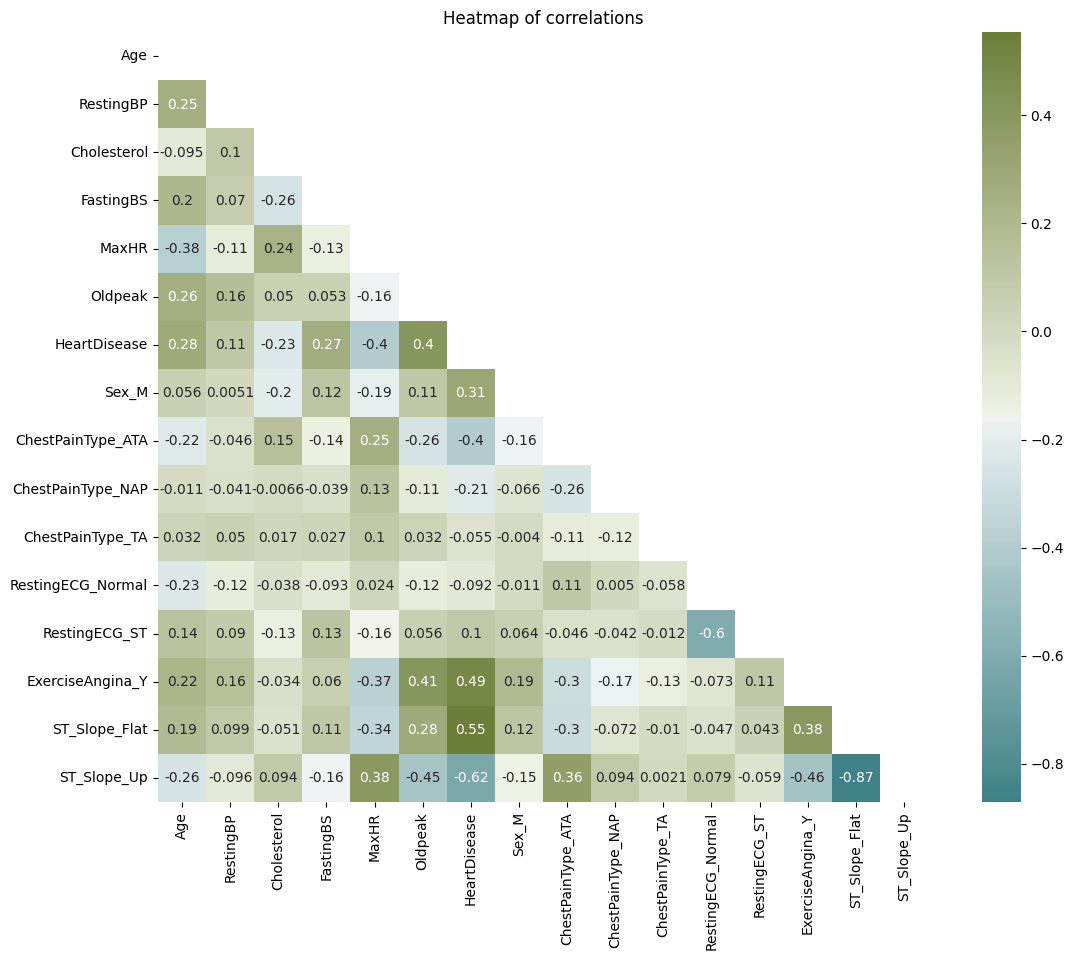

In [161]:
fig, ax = plt.subplots(figsize=(14, 10))
plt.title('Heatmap of correlations')
mask = np.triu(np.ones_like(cat_data.corr(), dtype=float))
cmap = sns.diverging_palette(200, 100, as_cmap=True)
sns.heatmap(cat_data.corr(), mask=mask, cmap=cmap, square=True, annot=True, fmt='.2g')
plt.show()

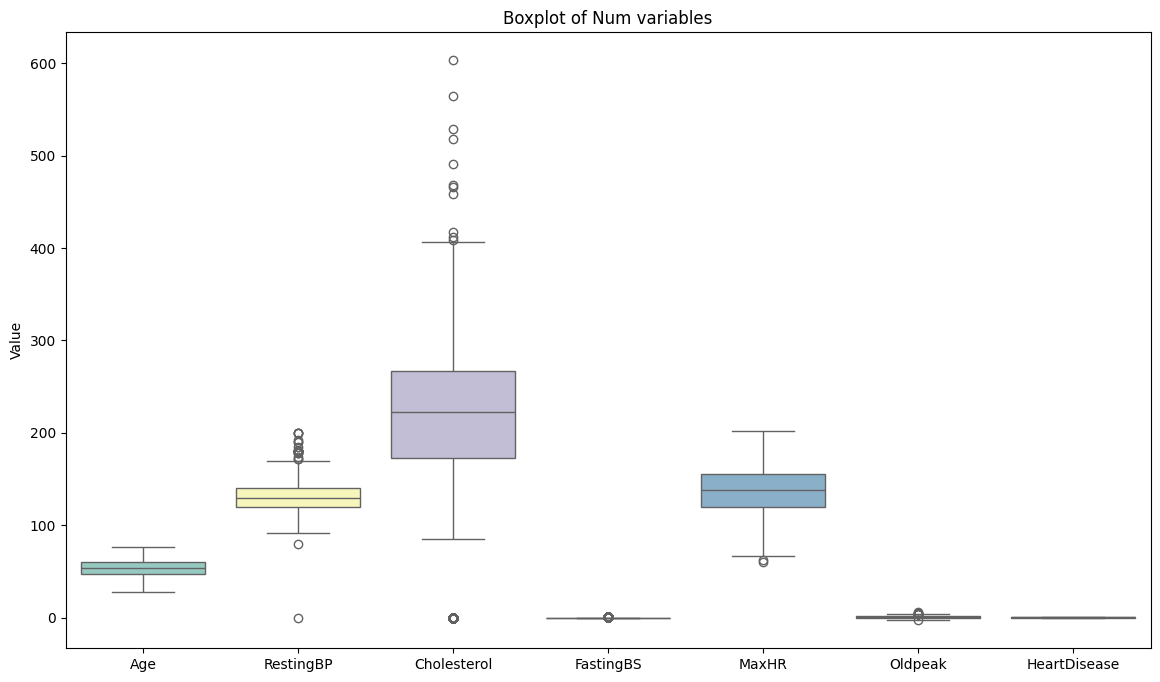

In [162]:
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(data=data, palette='Set3')
plt.title('Boxplot of Num variables')
plt.ylabel('Value')
plt.show()

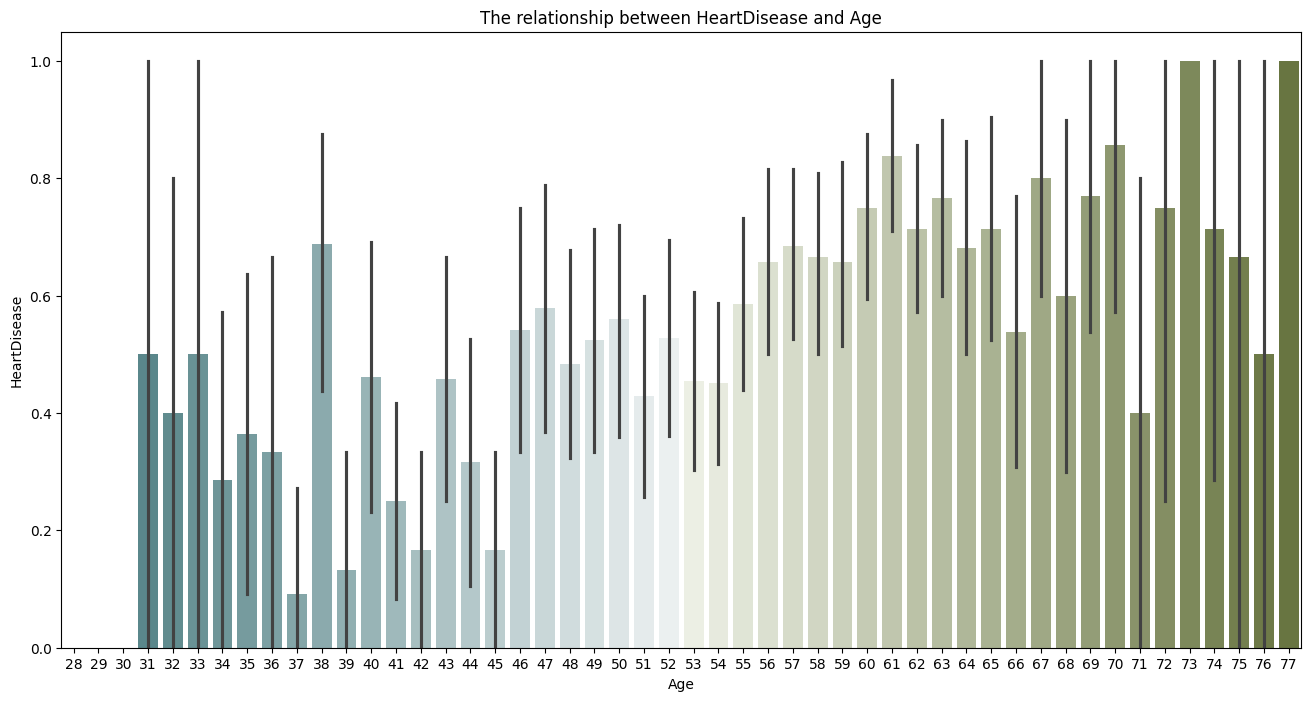

In [163]:
plt.figure(figsize=(16, 8))
sns.barplot(x='Age', y='HeartDisease', hue='Age', legend=False, data=data, palette=cmap)
plt.title('The relationship between HeartDisease and Age')
plt.xlabel('Age')
plt.ylabel('HeartDisease')
plt.show()

Некоторые признаки имеют выбросы, обработаем их после разделения на трейн и тест выборки.

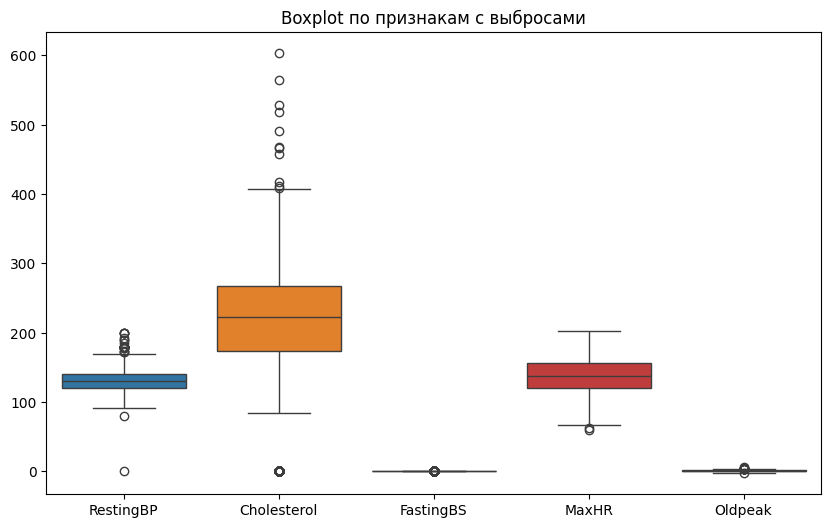

In [164]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=cat_data[['RestingBP',	'Cholesterol', 'FastingBS',	'MaxHR', 'Oldpeak']])
plt.title("Boxplot по признакам с выбросами")
plt.show()

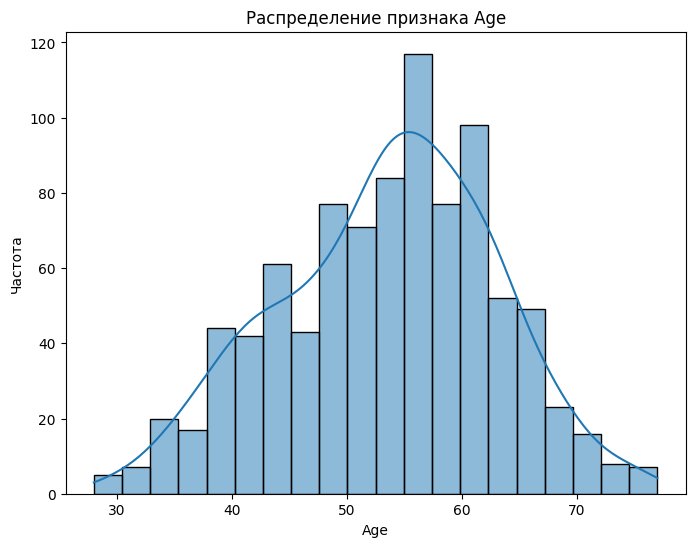

In [165]:
plt.figure(figsize=(8, 6))
sns.histplot(cat_data['Age'], bins=20, kde=True)
plt.title("Распределение признака Age")
plt.xlabel("Age")
plt.ylabel("Частота")
plt.show()

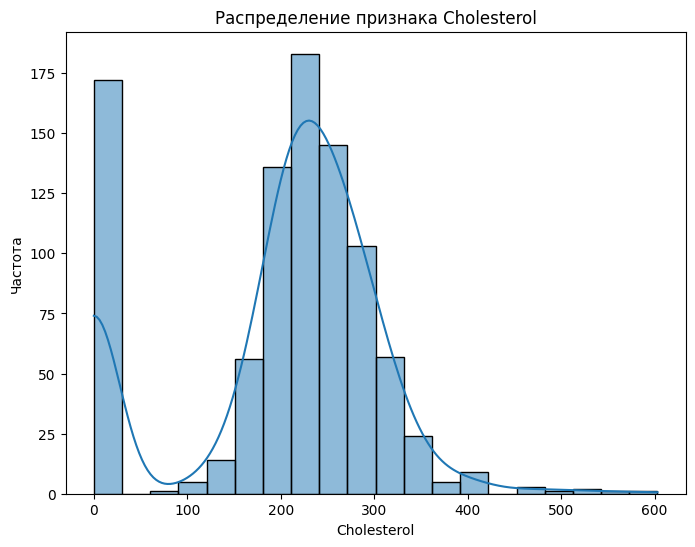

In [166]:
plt.figure(figsize=(8, 6))
sns.histplot(cat_data['Cholesterol'], bins=20, kde=True)
plt.title("Распределение признака Cholesterol")
plt.xlabel("Cholesterol")
plt.ylabel("Частота")
plt.show()

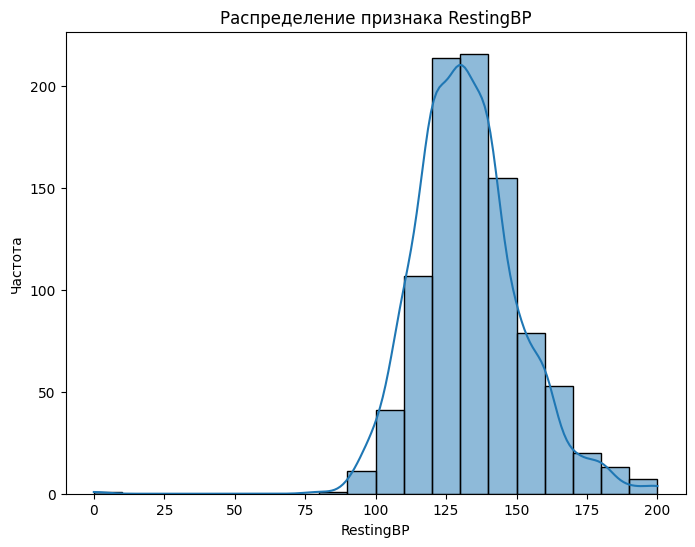

In [167]:
plt.figure(figsize=(8, 6))
sns.histplot(cat_data['RestingBP'], bins=20, kde=True)
plt.title("Распределение признака RestingBP")
plt.xlabel("RestingBP")
plt.ylabel("Частота")
plt.show()

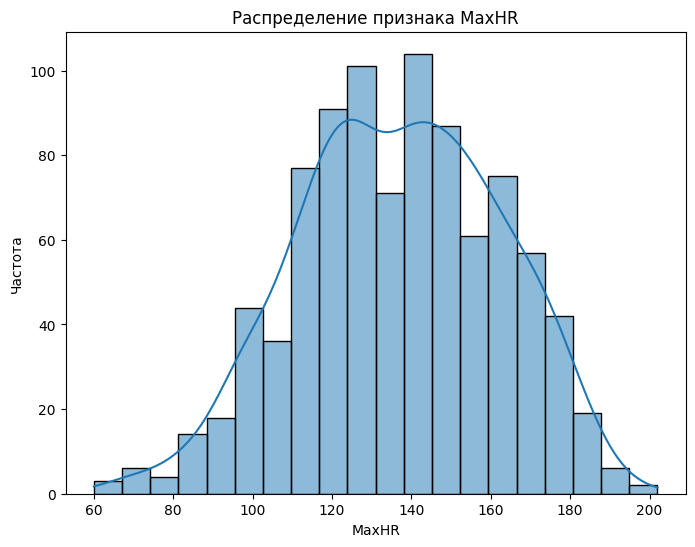

In [168]:
plt.figure(figsize=(8, 6))
sns.histplot(cat_data['MaxHR'], bins=20, kde=True)
plt.title("Распределение признака MaxHR")
plt.xlabel("MaxHR")
plt.ylabel("Частота")
plt.show()

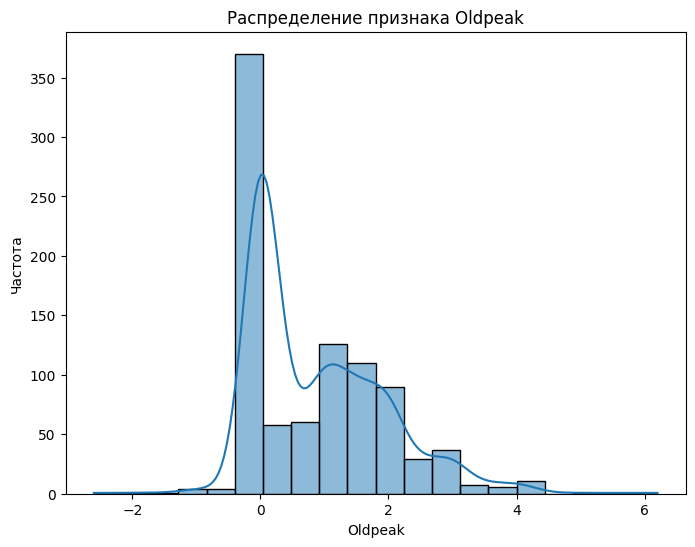

In [169]:
plt.figure(figsize=(8, 6))
sns.histplot(cat_data['Oldpeak'], bins=20, kde=True)
plt.title("Распределение признака Oldpeak")
plt.xlabel("Oldpeak")
plt.ylabel("Частота")
plt.show()

Определили распределение в данных, чтобы подобрать для каждого свой подход в "стандартизации"/"нормализации"

### 3. Разделите выборку на обучающее и тестовое подмножества. 80% данных оставить на обучающее множество, 20% - на тестовое.

In [170]:
X = cat_data.drop(columns=['HeartDisease'])
y = cat_data['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [171]:
sc = StandardScaler()
X_train[['MaxHR', 'RestingBP', 'Age']] = sc.fit_transform(X_train[['MaxHR', 'RestingBP', 'Age']])
X_test[['MaxHR', 'RestingBP', 'Age']] = sc.transform(X_test[['MaxHR', 'RestingBP', 'Age']])

In [172]:
mm_scaler = MinMaxScaler()
X_train[['Oldpeak', 'Cholesterol']] = mm_scaler.fit_transform(X_train[['Oldpeak', 'Cholesterol']])
X_test[['Oldpeak', 'Cholesterol']] = mm_scaler.transform(X_test[['Oldpeak', 'Cholesterol']])

### 4. Обучите дерево решений на обучающем множестве. Используйте следующие модели:
#### (A) tree.DecisionTreeClassifier

In [173]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

#### (B) ensemble.RandomForestClassifier

In [174]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### 5. Для тестового множества сделайте предсказание целевой переменной. Выведите метрики для каждой построенной модели с помощью metrics.classification_report.

In [175]:
y_pred_dt = dt_model.predict(X_test)

print("Decision Tree Classifier:")
dt_report = classification_report(y_test, y_pred_dt)
print(dt_report)

Decision Tree Classifier:
              precision    recall  f1-score   support

           0       0.78      0.81      0.79        77
           1       0.86      0.84      0.85       107

    accuracy                           0.83       184
   macro avg       0.82      0.82      0.82       184
weighted avg       0.83      0.83      0.83       184



In [176]:
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Classifier:")
rf_report = classification_report(y_test, y_pred_rf) 
print(rf_report)

Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85        77
           1       0.90      0.89      0.89       107

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.88      0.88      0.88       184



### 6. Выведите важность признаков, полученную после обучения модели из п. 4b в виде столбчатой диаграммы. Отсортируйте важность по убыванию.

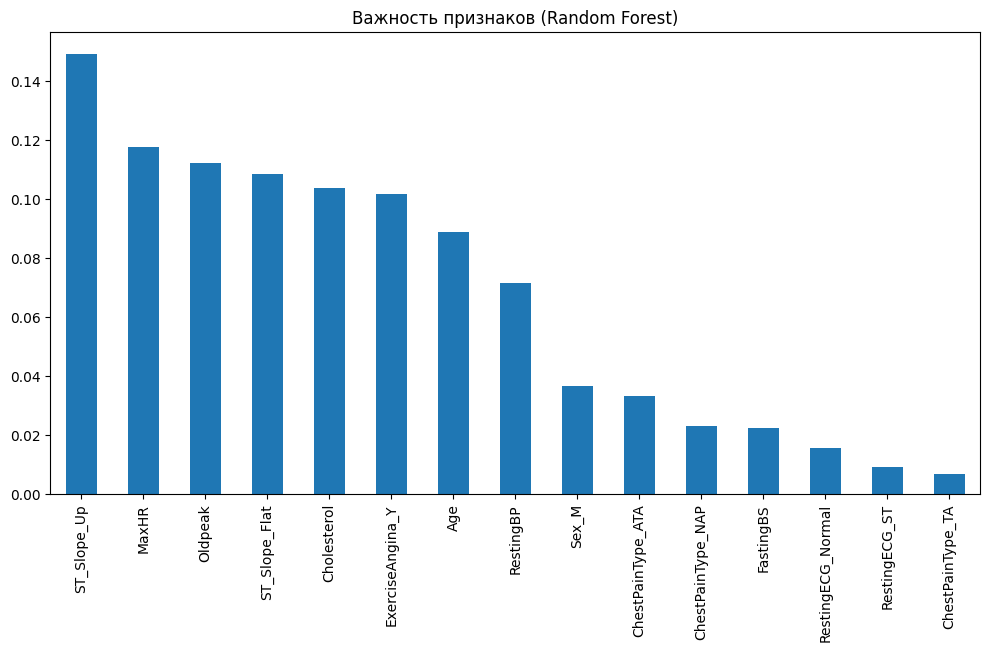

In [177]:
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))
plt.title('Важность признаков (Random Forest)')
plt.show()

### 7. Обучите бэггинг над моделью из п. 4a. Используйте ensemble.BaggingClassifier.
#### (A) Повторите п. 5

In [178]:
bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42)
bagging_model.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42)

In [179]:
y_pred_bagging = bagging_model.predict(X_test)

print("Bagging Classifier:")
bagging_report = classification_report(y_test, y_pred_bagging)
print(bagging_report)

Bagging Classifier:
              precision    recall  f1-score   support

           0       0.72      0.84      0.78        77
           1       0.87      0.77      0.82       107

    accuracy                           0.80       184
   macro avg       0.80      0.81      0.80       184
weighted avg       0.81      0.80      0.80       184



### 8. Обучите стекинг трех моделей: из п. 4a, п. 4b и svm.LinearSVC. Используйте ensemble.StackingClassifier.
#### (A) Повторите п. 5

In [185]:
estimators = [
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('svc', LinearSVC(random_state=42))
]

In [190]:
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_model.fit(X_train, y_train)

/home/nfrvnikita/study/netology/.venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/nfrvnikita/study/netology/.venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/nfrvnikita/study/netology/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nfrvnikita/study/netology/.venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/nfrvnikita/study/neto

StackingClassifier(estimators=[('dt', DecisionTreeClassifier(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', LinearSVC(random_state=42))],
                   final_estimator=LogisticRegression())

In [191]:
y_pred_stacking = stacking_model.predict(X_test)

print("Stacking Classifier:")
stack_report = classification_report(y_test, y_pred_stacking)
print(stack_report)

Stacking Classifier:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        77
           1       0.89      0.87      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184



### 9. Сформулируйте выводы по проделанной работе.
#### (A) Сравните метрики построенных моделей.

In [192]:
data = {
    'Model': ['Decision Tree', 'Random Forest', 'Stacking', 'Bagging'],
    'Accuracy': [accuracy_score(y_test, y_pred_dt), accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_stacking), accuracy_score(y_test, y_pred_bagging)],
    'Precision_0': [classification_report(y_test, y_pred_dt, output_dict=True)['0']['precision'], classification_report(y_test, y_pred_rf, output_dict=True)['0']['precision'], classification_report(y_test, y_pred_stacking, output_dict=True)['0']['precision'], classification_report(y_test, y_pred_bagging, output_dict=True)['0']['precision']],
    'Recall_0': [classification_report(y_test, y_pred_dt, output_dict=True)['0']['recall'], classification_report(y_test, y_pred_rf, output_dict=True)['0']['recall'], classification_report(y_test, y_pred_stacking, output_dict=True)['0']['recall'], classification_report(y_test, y_pred_bagging, output_dict=True)['0']['recall']],
    'F1-score_0': [classification_report(y_test, y_pred_dt, output_dict=True)['0']['f1-score'], classification_report(y_test, y_pred_rf, output_dict=True)['0']['f1-score'], classification_report(y_test, y_pred_stacking, output_dict=True)['0']['f1-score'], classification_report(y_test, y_pred_bagging, output_dict=True)['0']['f1-score']],
    'Precision_1': [classification_report(y_test, y_pred_dt, output_dict=True)['1']['precision'], classification_report(y_test, y_pred_rf, output_dict=True)['1']['precision'], classification_report(y_test, y_pred_stacking, output_dict=True)['1']['precision'], classification_report(y_test, y_pred_bagging, output_dict=True)['1']['precision']],
    'Recall_1': [classification_report(y_test, y_pred_dt, output_dict=True)['1']['recall'], classification_report(y_test, y_pred_rf, output_dict=True)['1']['recall'], classification_report(y_test, y_pred_stacking, output_dict=True)['1']['recall'], classification_report(y_test, y_pred_bagging, output_dict=True)['1']['recall']],
    'F1-score_1': [classification_report(y_test, y_pred_dt, output_dict=True)['1']['f1-score'], classification_report(y_test, y_pred_rf, output_dict=True)['1']['f1-score'], classification_report(y_test, y_pred_stacking, output_dict=True)['1']['f1-score'], classification_report(y_test, y_pred_bagging, output_dict=True)['1']['f1-score']]
}

# Создание датафрейма
metrics_df = pd.DataFrame(data)

In [193]:
metrics_df

,Model,Accuracy,Precision_0,Recall_0,F1-score_0,Precision_1,Recall_1,F1-score_1
0,Decision Tree,0.826087,0.784810,0.805195,0.794872,0.857143,0.841121,0.849057
1,Random Forest,0.875000,0.846154,0.857143,0.851613,0.896226,0.887850,0.892019
2,Stacking,0.864130,0.825000,0.857143,0.840764,0.894231,0.869159,0.881517
3,Bagging,0.798913,0.722222,0.844156,0.778443,0.872340,0.766355,0.815920


#### (B) Напишите свое мнение, какая модель наилучшая и почему.

- Лучше себя показал RandomForest, скорее всего это связано с тем, что размер выборки не очень велик. На малом количестве данных случайный лес себя лучше показывает.